In [1]:
# =======================
# 0) Imports y utilidades
# =======================
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO

# Haversine en km
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.asin(math.sqrt(a))

def build_distance_matrix(points):
    """points = [(lat, lon), ...] incluye índice 0 = depósito"""
    n = len(points)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i, j] = 0.0 if i == j else haversine_km(points[i][0], points[i][1], points[j][0], points[j][1])
    return D

In [4]:
# =========================================
# 1) Cargar datos (gold) SOLO desde Excel
# =========================================

import os
import pandas as pd
import numpy as np

# Cambia esta ruta si tu archivo está en otro lugar/nombre
PATH_GOLD = "/Users/johar/Desktop/Desarrollo/proyecto_dpd/data/3_gold/gold_tiendas_7d.xlsx"

REQUIRED_COLS = [
    "fecha","id","local","distrito","puntaje google","latitud","longitud",
    "productos disponibles","productos esperados","osa","estrato"
]

def parse_fecha_col(fecha_series: pd.Series) -> pd.Series:
    """
    Devuelve una columna auxiliar _fecha_dt en datetime.
    - Si 'fecha' ya es datetime -> la copia.
    - Si es número (serial Excel) -> convierte con origin=1899-12-30.
    - Si es string -> intenta to_datetime.
    """
    if pd.api.types.is_datetime64_any_dtype(fecha_series):
        return fecha_series.copy()
    s = fecha_series.copy()
    # intenta como número (serial excel)
    try:
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().any():
            return pd.to_datetime(s_num, unit="D", origin="1899-12-30", errors="coerce")
    except Exception:
        pass
    # intenta como string fecha
    return pd.to_datetime(s, errors="coerce")

def load_gold_xlsx(path: str) -> pd.DataFrame:
    if not os.path.isfile(path):
        raise FileNotFoundError(
            f"❌ No encontré el archivo GOLD en:\n{path}\n"
            "Verifica la ruta/nombre o actualiza PATH_GOLD."
        )
    df = pd.read_excel(path)
    # normaliza columnas a minúsculas
    df.columns = [c.strip().lower() for c in df.columns]

    # valida columnas requeridas
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(
            "❌ Faltan columnas requeridas en el GOLD:\n"
            f"- Faltan: {missing}\n"
            f"- Columnas presentes: {list(df.columns)}"
        )

    # tipos numéricos clave
    for c in ["puntaje google","latitud","longitud","productos disponibles","productos esperados","osa"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # columna fecha auxiliar en datetime (sin tocar el valor original)
    df["_fecha_dt"] = parse_fecha_col(df["fecha"])

    # ordena por fecha e id por comodidad
    df = df.sort_values(["_fecha_dt","id"]).reset_index(drop=True)
    return df

# Carga definitiva (SIN fallback a datos crudos)
df = load_gold_xlsx(PATH_GOLD)
print(f"✔ Cargado GOLD: {PATH_GOLD}  (filas={len(df)})")
display(df.head())

✔ Cargado GOLD: /Users/johar/Desktop/Desarrollo/proyecto_dpd/data/3_gold/gold_tiendas_7d.xlsx  (filas=35)


,fecha,id,local,distrito,puntaje google,latitud,longitud,productos disponibles,productos esperados,osa,estrato,_fecha_dt
0,2025-10-26,TAM0001,Tambo Angamos,Miraflores,4.0,-12.113606,-77.030359,25,32,78.12,A,2025-10-26
1,2025-10-26,TCL0001,Tambo Cardenas,Lince,3.8,-12.077001,-77.034510,21,29,72.41,B,2025-10-26
2,2025-10-26,TCLV0001,Tambo Canada,La Victoria,3.7,-12.082462,-77.012664,22,32,68.75,C,2025-10-26
3,2025-10-26,TMEA0001,Tambo Mariategui,El Agustino,2.3,-12.030028,-76.998899,19,30,63.33,D,2025-10-26
4,2025-10-26,TUB0665,Tambo UTEC,Barranco,3.4,-12.135885,-77.022519,22,31,70.97,B,2025-10-26


In [5]:
# =======================================
# 2) Elegir el día a optimizar (si hay n)
# =======================================
# Si solo tienes un día, esto toma el mínimo; cambia a otro valor si quieres.
dias = sorted(df["fecha"].unique().tolist())
DAY = dias[0]  # <- cámbialo para otro día si hay más
print("Día elegido (serial Excel):", DAY)

df_day = df[df["fecha"] == DAY].copy()
assert len(df_day) >= 1, "No hay filas para el día seleccionado."

df_day[["_fecha_dt","id","local","distrito","osa","estrato","productos disponibles","productos esperados"]]

Día elegido (serial Excel): 2025-10-26 00:00:00


,_fecha_dt,id,local,distrito,osa,estrato,productos disponibles,productos esperados
0,2025-10-26,TAM0001,Tambo Angamos,Miraflores,78.12,A,25,32
1,2025-10-26,TCL0001,Tambo Cardenas,Lince,72.41,B,21,29
2,2025-10-26,TCLV0001,Tambo Canada,La Victoria,68.75,C,22,32
3,2025-10-26,TMEA0001,Tambo Mariategui,El Agustino,63.33,D,19,30
4,2025-10-26,TUB0665,Tambo UTEC,Barranco,70.97,B,22,31


In [6]:
# ==========================================================
# 3) Depósito (ArcaContinental) y matriz de distancias Haversine
# ==========================================================
depot_lat, depot_lon = -12.068071984223696, -76.94734607980992

points = [(depot_lat, depot_lon)] + list(zip(df_day["latitud"], df_day["longitud"]))
D = build_distance_matrix(points)

print("Nodos (incluye depot=0):", len(points))

Nodos (incluye depot=0): 6


In [7]:
# =========================================
# 4) Prioridad: OSA baja + estrato + demanda
# =========================================

#	•	Menor OSA ⇒ mayor prioridad
#	•	Estrato: D > C > B > A
#	•	Brecha de demanda: productos_esperados - productos_disponibles


estrato_weight = {"A": 0.10, "B": 0.20, "C": 0.30, "D": 0.40}

osa_priority = 1.0 - (df_day["osa"].values / 100.0)  # 0..1  (OSA baja -> prioridad alta)
estr_priority = np.array([estrato_weight.get(str(e).upper(), 0.25) for e in df_day["estrato"]])

gap = (df_day["productos esperados"].values - df_day["productos disponibles"].values).astype(float)
gap_norm = (gap / gap.max()) if gap.max() > 0 else np.zeros_like(gap)

# Ponderaciones (ajusta a tu gusto)
W_OSA, W_ESTR, W_GAP = 0.6, 0.3, 0.1
priority = W_OSA*osa_priority + W_ESTR*estr_priority + W_GAP*gap_norm
df_day["priority_score"] = priority

df_day[["id","local","osa","estrato","productos disponibles","productos esperados","priority_score"]]

,id,local,osa,estrato,productos disponibles,productos esperados,priority_score
0,TAM0001,Tambo Angamos,78.12,A,25,32,0.224916
1,TCL0001,Tambo Cardenas,72.41,B,21,29,0.298267
2,TCLV0001,Tambo Canada,68.75,C,22,32,0.368409
3,TMEA0001,Tambo Mariategui,63.33,D,19,30,0.440020
4,TUB0665,Tambo UTEC,70.97,B,22,31,0.315998


In [8]:
# ================================================
# 5) Solver: Pyomo (si hay glpk/cbc) o Heurístico
# ================================================
route = None
used_solver = None
objective_value = None

n = len(points)              # incluye depot
C = list(range(1, n))        # clientes = 1..n-1

try:
    import pyomo.environ as pyo

    m = pyo.ConcreteModel()
    m.N = pyo.Set(initialize=list(range(n)))
    m.C = pyo.Set(initialize=C)

    # Vars
    m.x = pyo.Var(m.N, m.N, domain=pyo.Binary)         # arcos
    m.u = pyo.Var(m.C, bounds=(1, len(C)), domain=pyo.Reals)  # orden (MTZ)

    # Sin bucles i->i
    def no_self(m, i):
        return m.x[i, i] == 0
    m.no_self = pyo.Constraint(m.N, rule=no_self)

    # Grado de salida/entrada = 1
    def outdeg(m, i):
        return sum(m.x[i, j] for j in m.N if j != i) == 1
    def indeg(m, j):
        return sum(m.x[i, j] for i in m.N if i != j) == 1
    m.outdeg = pyo.Constraint(m.N, rule=outdeg)
    m.indeg  = pyo.Constraint(m.N, rule=indeg)

    # MTZ subtours
    M = len(C)
    def mtz(m, i, j):
        if i != j:
            return m.u[i] - m.u[j] + M*m.x[i, j] <= M - 1
        return pyo.Constraint.Skip
    m.mtz = pyo.Constraint(m.C, m.C, rule=mtz)

    # Distancia + lambda * (prioridad * posición)
    # Nota: m.u[i] ≈ posición de visita del cliente i (1..n-1)
    LAMBDA = 1.0  # ajusta tradeoff distancia vs prioridad (sube -> prioriza más)
    def obj(m):
        dist = sum(D[i, j] * m.x[i, j] for i in m.N for j in m.N)
        prio = sum(float(priority[i-1]) * m.u[i] for i in m.C)  # i-1 para mapear a filas df_day
        return dist + LAMBDA*prio
    m.obj = pyo.Objective(rule=obj, sense=pyo.minimize)

    # Elegir solver disponible
    solver = None
    for cand in ("glpk","cbc"):
        s = pyo.SolverFactory(cand)
        if s is not None and s.available():
            solver = s
            break
    if solver is None:
        raise RuntimeError("No MILP solver found")

    res = solver.solve(m, tee=False)
    used_solver = solver.name

    # sucesores
    succ = {}
    for i in range(n):
        for j in range(n):
            if i != j and pyo.value(m.x[i, j]) > 0.5:
                succ[i] = j
                break

    # reconstruir ciclo: 0 -> ... -> 0
    seq = [0]
    while True:
        nxt = succ[seq[-1]]
        seq.append(nxt)
        if nxt == 0:
            break

    # ruta sin el depósito en extremos
    route = [i for i in seq[1:-1]]
    objective_value = pyo.value(m.obj)

except Exception as e:
    used_solver = f"Heurístico ({type(e).__name__})"

    # Vecino más cercano con sesgo por prioridad + 2-opt
    remaining = C.copy()
    current = 0
    route = []
    while remaining:
        alpha = 5.0  # penaliza postergar prioritarios
        nxt = min(remaining, key=lambda k: D[current, k] + alpha*priority[k-1])
        route.append(nxt)
        remaining.remove(nxt)
        current = nxt

    def route_score(rt):
        dist = D[0, rt[0]] + sum(D[rt[i], rt[i+1]] for i in range(len(rt)-1)) + D[rt[-1], 0]
        pen  = sum(priority[rt[i]-1]*(i+1) for i in range(len(rt)))  # posición 1..m
        return dist + 1.0*pen

    improved = True
    while improved:
        improved = False
        best = route_score(route)
        for i in range(1, len(route)-1):
            for k in range(i+1, len(route)):
                new_rt = route[:i] + route[i:k+1][::-1] + route[k+1:]
                sc = route_score(new_rt)
                if sc + 1e-9 < best:
                    route = new_rt
                    best  = sc
                    improved = True

,orden,id,local,distrito,estrato,OSA,priority
0,1,TCLV0001,Tambo Canada,La Victoria,C,68.75,0.368
1,2,TUB0665,Tambo UTEC,Barranco,B,70.97,0.316
2,3,TAM0001,Tambo Angamos,Miraflores,A,78.12,0.225
3,4,TCL0001,Tambo Cardenas,Lince,B,72.41,0.298
4,5,TMEA0001,Tambo Mariategui,El Agustino,D,63.33,0.440


Solver: Heurístico (RuntimeError)
Distancia total (km, ida+vuelta): 33.56


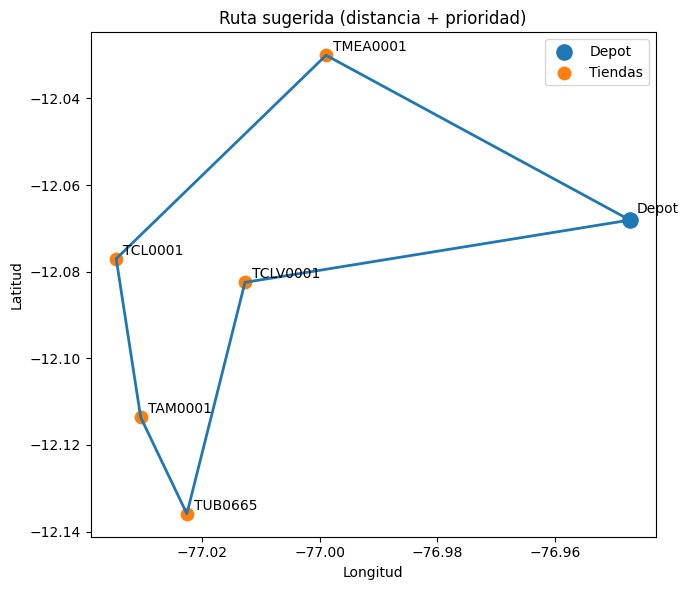

In [9]:
# ===========================
# 6) Resumen y gráfico simple
# ===========================
def route_distance_km(rt, D):
    if not rt: return 0.0
    return D[0, rt[0]] + sum(D[rt[i], rt[i+1]] for i in range(len(rt)-1)) + D[rt[-1], 0]

ids   = [df_day.iloc[i-1]["id"] for i in route]
names = [df_day.iloc[i-1]["local"] for i in route]
km    = route_distance_km(route, D)

summary = pd.DataFrame({
    "orden": range(1, len(route)+1),
    "id": ids,
    "local": names,
    "distrito": [df_day.iloc[i-1]["distrito"] for i in route],
    "estrato":  [df_day.iloc[i-1]["estrato"]  for i in route],
    "OSA":      [df_day.iloc[i-1]["osa"]      for i in route],
    "priority": [round(df_day.iloc[i-1]["priority_score"],3) for i in route],
})
display(summary)

print(f"Solver: {used_solver}")
print(f"Distancia total (km, ida+vuelta): {km:.2f}")
if objective_value is not None:
    print(f"Valor objetivo (dist + prioridad): {objective_value:.3f}")

# Plot
plt.figure(figsize=(7,6))
# Depósito
plt.scatter([depot_lon],[depot_lat], s=120, label="Depot")
plt.annotate("Depot", (depot_lon,depot_lat), xytext=(5,5), textcoords="offset points")
# Tiendas
plt.scatter(df_day["longitud"], df_day["latitud"], s=80, label="Tiendas")
for i,row in df_day.iterrows():
    plt.annotate(row["id"], (row["longitud"], row["latitud"]), xytext=(5,3), textcoords="offset points")
# Líneas de ruta
lon = [depot_lon] + [df_day.iloc[i-1]["longitud"] for i in route] + [depot_lon]
lat = [depot_lat] + [df_day.iloc[i-1]["latitud"] for i in route] + [depot_lat]
plt.plot(lon, lat, linewidth=2)

plt.title("Ruta sugerida (distancia + prioridad)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.tight_layout()
plt.show()

Se atiende primero a las tiendas con menor OSA, mayor vulnerabilidad (estrato D > C > B > A) y mayor brecha entre esperados y disponibles.
